In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [7]:
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout
import random
import sklearn as sk
from time import time
import pickle
from Lopacity import *

In [59]:
g = nx.erdos_renyi_graph(n=200, p=0.15)

# Init graph 
degs = g.degree(g)
deg_count, opacity = init(g, degs)
# Prepare inverted opacity matrix:
inv_opacity = {}


In [3]:
face_orig = open("data/facebook-links.txt") 
f_arr = np.array(face_orig.readlines())
G = nx.Graph()

edgelist = []
for line in f_arr: 
    i, j, time = line.split('\t')
    edgelist.append((int(i), int(j)))

G.add_edges_from(edgelist)


### Split the graph

In [9]:
def edge_split(G, alpha_v, save_as=""):
    V = np.array(G.edges())
    random.shuffle(V)
    a = int((1-alpha_v)/2 * len(V))
    b = int(alpha_v * len(V))
    Va = V[:a]
    Vb =  V[a:a+b]
    Vc =  V[a+b:2*a+b]
    V1 = np.concatenate((Va, Vb))
    V2 = np.concatenate((Vb, Vc))
    G1 = nx.Graph()
    G1.add_edges_from(V1)
    G2 = nx.Graph()
    G2.add_edges_from(V2)
    if save_as != '': 
        nx.write_edgelist(G1, 'data/'+str(alpha_v)+save_as+'_aux.edgelist')
        nx.write_edgelist(G2, 'data/'+str(alpha_v)+save_as+'_san.edgelist')
    return G1, G2

In [60]:
G1, G2 = edge_split(g, 0.25)

In [61]:
G_aux = G1
G_san = G2

In [22]:
## Apply anonimization
def anonimize(G):
    return G
G_aux = anonimize(G1)
G_san = anonimize(G2)

In [39]:
L = 2
theta = 0.5

In [40]:
def anonimize(g):
    t1 = time()
    result_optval2 = intersect_anonimize(g, L, theta, score='opt2', mode = 'val')
    tot_time = time()-t1
    print("Total time "+ str(tot_time))

    g1 = result_optval2['new_graph']
    dist = (g.number_of_edges() - g1.number_of_edges())/g.number_of_edges()
    print("Distortion "+ str(dist))
    return g1

In [42]:
def anonimize_orig(g):
    t1 = time()
    result_lomax = anonimize_lopacity(g=g, L=L, theta=theta, mode='max')
    print("Total time "+ str(time()-t1))

    # Storing results:
    g1 = result_lomax['new_graph']
    dist = (g.number_of_edges() - g1.number_of_edges())/g.number_of_edges()
    print("Distortion "+ str(dist))
    return g1

In [72]:
G_aux = anonimize(G1)

Edges removed: 
[(6, 144)]
Edges removed: 
[(13, 123)]
Edges removed: 
[(13, 87)]
Edges removed: 
[(5, 104)]
Edges removed: 
[(15, 198)]
Edges removed: 
[(0, 198)]
Edges removed: 
[(2, 135)]
Edges removed: 
[(4, 135)]
Edges removed: 
[(0, 156)]
Edges removed: 
[(2, 144)]
Edges removed: 
[(2, 155)]
Edges removed: 
[(2, 198)]
Edges removed: 
[(3, 173)]
Edges removed: 
[(24, 29)]
Edges removed: 
[(19, 106)]
Edges removed: 
[(12, 135)]
Edges removed: 
[(2, 156)]
Edges removed: 
[(3, 156)]
Edges removed: 
[(20, 156)]
Edges removed: 
[(19, 156)]
Edges removed: 
[(2, 191)]
Edges removed: 
[(5, 191)]
Edges removed: 
[(47, 198)]
Edges removed: 
[(15, 170)]
Edges removed: 
[(24, 156)]
Edges removed: 
[(8, 135)]
Edges removed: 
[(2, 48)]
Edges removed: 
[(24, 3)]
Edges removed: 
[(15, 191)]
Edges removed: 
[(5, 69)]
Edges removed: 
[(0, 141)]
Edges removed: 
[(18, 141)]
Edges removed: 
[(12, 141)]
Edges removed: 
[(9, 141)]
Edges removed: 
[(4, 32)]
Edges removed: 
[(7, 84)]
Edges removed: 
[(17,

In [73]:
G_san = anonimize(G2)

Edges removed: 
[(35, 75)]
Edges removed: 
[(51, 167)]
Edges removed: 
[(35, 128)]
Edges removed: 
[(21, 195)]
Edges removed: 
[(58, 178)]
Edges removed: 
[(15, 151)]
Edges removed: 
[(22, 97)]
Edges removed: 
[(2, 169)]
Edges removed: 
[(6, 124)]
Edges removed: 
[(47, 198)]
Edges removed: 
[(30, 186)]
Edges removed: 
[(41, 120)]
Edges removed: 
[(4, 110)]
Edges removed: 
[(12, 160)]
Edges removed: 
[(43, 28)]
Edges removed: 
[(6, 144)]
Edges removed: 
[(18, 168)]
Edges removed: 
[(19, 134)]
Edges removed: 
[(56, 186)]
Edges removed: 
[(11, 34)]
Edges removed: 
[(4, 135)]
Edges removed: 
[(27, 7)]
Edges removed: 
[(84, 134)]
Edges removed: 
[(15, 149)]
Edges removed: 
[(1, 35)]
Edges removed: 
[(46, 160)]
Edges removed: 
[(71, 121)]
Edges removed: 
[(33, 68)]
Edges removed: 
[(68, 165)]
Edges removed: 
[(0, 198)]
Edges removed: 
[(74, 66)]
Edges removed: 
[(41, 118)]
Edges removed: 
[(4, 9)]
Edges removed: 
[(5, 86)]
Edges removed: 
[(83, 167)]
Edges removed: 
[(67, 167)]
Edges removed

In [62]:
str(G_aux.number_of_nodes())+  ' vs '  +  str(G_san.number_of_edges())

'200 vs 1298'

### Train data

In [74]:
G_a1, G_a2 = edge_split(G_aux, 0.25) # aux 
G_s1, G_s2 = edge_split(G_san, 0.25) # sanitized

In [75]:
'''
 Get the histogram of degree distribution for an node 'n' in a graph 'G' 
     bins - the number of bins in the deg. distribution 
     size - size of the historgram 
'''
def deg_dist(G, n, bins, size):
    feature_set = [0 for i in range(2*bins)]
    _1hop = G[n]
    _1hop = G.degree(_1hop).values()
    for h in _1hop:
        if h < bins*size:
            feature_set[int(h/size)] += 1
    _prev = set(nx.single_source_shortest_path_length(G, n, cutoff=1).keys())
    _2hop = set(nx.single_source_shortest_path_length(G, n, cutoff=2).keys())
    _2hop = _2hop - _prev
    _2hop = G.degree(_2hop).values()
    for h in _2hop:
        if h < bins*size:
            feature_set[bins+int(h/size)] += 1
    return feature_set


''' Get the feature vector for egde e1 in graph G1
     and e2 in graph G2.
     1hop, 2hop deg distributions
     + 4 Silhoutte coefficients
'''    
def e_feature(G1, e1, G2, e2,  bins = 21, size = 50):
    feature_set = [0 for i in range(8*bins)]
    for j in [0, 1]:
        f_set = deg_dist(G1, e1[j], bins, size)
        for i in range(len(f_set)):
            feature_set[2*bins*j + i] += f_set[i]
    for j in [0, 1]:
        f_set = deg_dist(G2, e2[j], bins, size)
        for i in range(len(f_set)):
            feature_set[4*bins+2*bins*j + i] += f_set[i]
    
    # 4 Silhouette Coefficients 
    e1_deg0 = G1.degree(e1[0])
    e1_deg1 = G1.degree(e1[1])
    
    e2_deg0 = G2.degree(e2[0])
    e2_deg1 = G2.degree(e2[1])
    
    feature_set.append(abs(e1_deg0-e2_deg0)/max(e1_deg0, e2_deg0, 1))
    feature_set.append(abs(e1_deg1-e2_deg1)/max(e1_deg1, e2_deg1, 1))
    feature_set.append(abs(e1_deg0-e2_deg1)/max(e1_deg0, e2_deg1, 1))
    feature_set.append(abs(e1_deg1-e2_deg0)/max(e1_deg1, e2_deg0, 1))
    
    return feature_set

'''
    Transform graph into feature vector dataset
    G1, G2 - graphs for comparison
'''
def fill_set(G1, G2, data, labels, n_max=None):
    indx = 0
    total = len(G1.nodes())
    # report every 10 % 
    part = total//10
    # Add all intersections first: 
    print('Start adding positive examples')
    common = set(G1.edges()) & set(G2.edges())
    if n_max is None: 
        n_max = len(common)
    common = random.sample(common, n_max)
    indx = 0
    for i in common: 
        data.append(e_feature(G1,i, G2, i))
        labels.append(1)
        indx += 1
        if indx % int(len(common)/10) ==0:
            print("Finished : " + str(indx/len(common)))
        
    g1 = set(G1.edges()) - set(common)
    g2 = set(G2.edges()) - set(common)
    
    # How many false results to add ? - 
    # The same size as common
    # TODO: 
    print('Start adding false examples')
    if len(g1) < n_max:
        n_max = min(len(g1), len(g2))
    g1 = random.sample(g1, n_max)
    g2 = random.sample(g2, n_max)
    for i in range(len(g1)):
        data.append(e_feature(G1, g1[i], G2, g2[i]))
        labels.append(0)
        if i % int(len(g1)/10) ==0:
            print("Finished : " + str(i/len(g1)))

In [76]:
# Generating train dataset: 
train_set = []
train_labels = []
s = time()
print("Dataset is generating ... ")
fill_set(G_a1, G_a2, train_set, train_labels, n_max=None)
e = time()
print("Aux finished " + str(e-s) + " sec")
s = time()
fill_set(G_s1, G_s2, train_set, train_labels, n_max=None)
e = time()
print("San finished " + str(e-s) + " sec")
pickle.dump( (train_set, train_labels), open( "data/train_edge_face.set", "wb" ) )

Dataset is generating ... 
Start adding positive examples
Finished : 0.09558823529411764
Finished : 0.19117647058823528
Finished : 0.2867647058823529
Finished : 0.38235294117647056
Finished : 0.47794117647058826
Finished : 0.5735294117647058
Finished : 0.6691176470588235
Finished : 0.7647058823529411
Finished : 0.8602941176470589
Finished : 0.9558823529411765
Start adding false examples
Finished : 0.0
Finished : 0.09090909090909091
Finished : 0.18181818181818182
Finished : 0.2727272727272727
Finished : 0.36363636363636365
Finished : 0.45454545454545453
Finished : 0.5454545454545454
Finished : 0.6363636363636364
Finished : 0.7272727272727273
Finished : 0.8181818181818182
Finished : 0.9090909090909091
Aux finished 0.08351683616638184 sec
Start adding positive examples
Finished : 0.09606986899563319
Finished : 0.19213973799126638
Finished : 0.28820960698689957
Finished : 0.38427947598253276
Finished : 0.48034934497816595
Finished : 0.5764192139737991
Finished : 0.6724890829694323
Finished

In [77]:
from sklearn.ensemble import RandomForestClassifier

In [78]:
forest = RandomForestClassifier(n_estimators = 400, n_jobs=8)
forest.fit(train_set, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=400, n_jobs=8, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [79]:
test_set = []
test_labels = []
s = time()
print("Dataset is generating ... ")
fill_set(G_aux, G_san, test_set, test_labels, n_max=None)
e = time()
print("Test set generated in  " + str(e-s) + " sec")
pickle.dump( (test_set, test_labels), open( "data/test_edge_face.set", "wb" ) )

Dataset is generating ... 
Start adding positive examples
Finished : 0.09764309764309764
Finished : 0.19528619528619529
Finished : 0.29292929292929293
Finished : 0.39057239057239057
Finished : 0.4882154882154882
Finished : 0.5858585858585859
Finished : 0.6835016835016835
Finished : 0.7811447811447811
Finished : 0.8787878787878788
Finished : 0.9764309764309764
Start adding false examples
Finished : 0.0
Finished : 0.09829059829059829
Finished : 0.19658119658119658
Finished : 0.2948717948717949
Finished : 0.39316239316239315
Finished : 0.49145299145299143
Finished : 0.5897435897435898
Finished : 0.688034188034188
Finished : 0.7863247863247863
Finished : 0.8846153846153846
Finished : 0.9829059829059829
Test set generated in  0.5161821842193604 sec


In [80]:
forest.score(test_set, test_labels)

0.55932203389830504

In [70]:
from sklearn.metrics import roc_curve, auc
y_score = forest.predict_proba(test_set)
y_true = test_labels
fpr, tpr, thresholds = roc_curve(y_true, y_score[:, 1])
roc_auc = auc(fpr, tpr)

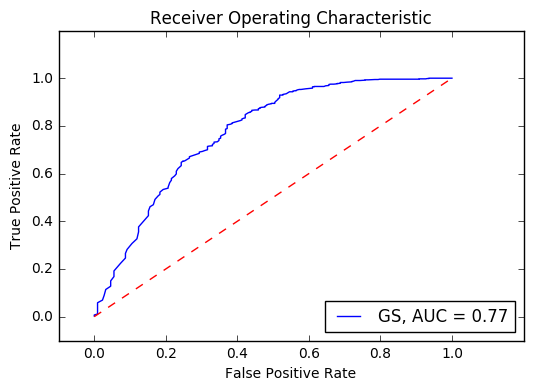

In [71]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='GS, AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [81]:
from sklearn.metrics import roc_curve, auc
y_score = forest.predict_proba(test_set)
y_true = test_labels
fpr, tpr, thresholds = roc_curve(y_true, y_score[:, 1])
roc_auc = auc(fpr, tpr)

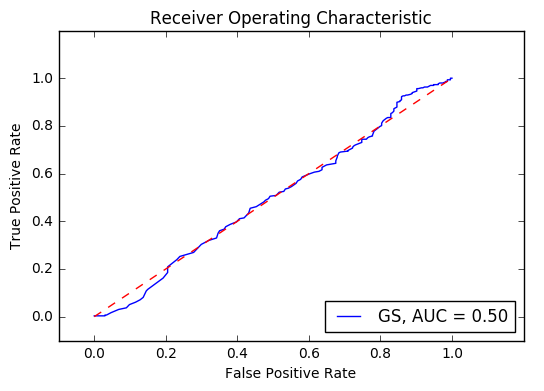

In [82]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',
label='GS, AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()